In [1]:
# for the first time, run the init_data.sh to clone the Johns Hopkins COVID data
!./pull_data.sh

remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Total 49 (delta 34), reused 34 (delta 34), pack-reused 15
Unpacking objects: 100% (49/49), done.
From https://github.com/CSSEGISandData/COVID-19
   4ddc4859..865c933c  master     -> origin/master
   1e368489..8cdb4174  web-data   -> origin/web-data
Updating 4ddc4859..865c933c
Fast-forward
 .../csse_covid_19_daily_reports/04-05-2020.csv     | 2765 +++++++++
 .../time_series_covid19_confirmed_US.csv           | 6508 ++++++++++----------
 .../time_series_covid19_confirmed_global.csv       |  523 +-
 .../time_series_covid19_deaths_US.csv              | 6508 ++++++++++----------
 .../time_series_covid19_deaths_global.csv          |  523 +-
 .../time_series_covid19_recovered_global.csv       |  495 +-
 6 files changed, 10048 insertions(+), 7274 deletions(-)
 create mode 100644 csse_covid_19_data/csse_covid_19_daily_reports/04-05-2020.csv


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
from sklearn import preprocessing
import datetime
%matplotlib inline


##
## read the csse daily report files
## align the columns, and rename them to common column names
##
path = "../COVID-19-data/csse_covid_19_data/csse_covid_19_daily_reports" # use your path
all_files = glob.glob(path + "/*.csv")

essential_cols = ["Country_Region","Country/Region","Last Update","Last_Update","Confirmed","Deaths"]
ess_col_names = ["Country_Region","Last_Update_Time","Confirmed","Deaths"]

nfiles_read = 0
list_dfs = []
for filepath in all_files:
    df = pd.read_csv(filepath, index_col=None, header=0, sep=",")
    ## delete non-essential columns
    del_cols = list(set(df.columns)-set(essential_cols))
    df = df.drop(columns=del_cols)
    ## Rename the columns to be the same across all files
    ## note the sequence of cols in each file is the same
    df.columns = ess_col_names
    list_dfs.append(df)
    nfiles_read += 1

# Put together all the data read from the files
cssedf = pd.concat(list_dfs, axis=0, ignore_index=True)
cssedf['Last_Update_Time']= pd.to_datetime(cssedf['Last_Update_Time'])

## Fix the names of a bunch of countries, align them with the other data files
cssedf.loc[cssedf['Country_Region'] == " Azerbaijan", 'Country_Region'] = "Azerbaijan"
cssedf.loc[cssedf['Country_Region'] == "UK", 'Country_Region'] = "United Kingdom"
cssedf.loc[cssedf['Country_Region'] == "North Ireland", 'Country_Region'] = "United Kingdom"
cssedf.loc[cssedf['Country_Region'] == "US", 'Country_Region'] = "United States"
cssedf.loc[cssedf['Country_Region'] == "Puerto Rico", 'Country_Region'] = "United States"
cssedf.loc[cssedf['Country_Region'] == "Korea, South", 'Country_Region'] = "South Korea"
cssedf.loc[cssedf['Country_Region'] == "Republic of Korea", 'Country_Region'] = "North Korea"
cssedf.loc[cssedf['Country_Region'] == "Burma", 'Country_Region'] = "Myanmar"
cssedf.loc[cssedf['Country_Region'] == "Iran (Islamic Republic of)", 'Country_Region'] = "Iran"
cssedf.loc[cssedf['Country_Region'] == "Viet Nam", 'Country_Region'] = "Vietnam"
cssedf.loc[cssedf['Country_Region'] == "Bahamas, The", 'Country_Region'] = "Bahamas"
cssedf.loc[cssedf['Country_Region'] == "The Bahamas", 'Country_Region'] = "Bahamas"
cssedf.loc[cssedf['Country_Region'] == "Czechia", 'Country_Region'] = "Czech Republic"
cssedf.loc[cssedf['Country_Region'] == "Gambia, The", 'Country_Region'] = "Gambia"
cssedf.loc[cssedf['Country_Region'] == "The Gambia", 'Country_Region'] = "Gambia"
cssedf.loc[cssedf['Country_Region'] == "Taiwan*", 'Country_Region'] = "Taiwan"
cssedf.loc[cssedf['Country_Region'] == "Republic of Moldova", 'Country_Region'] = "Moldova"
cssedf.loc[cssedf['Country_Region'] == "Republic of the Congo", 'Country_Region'] = "Congo"
cssedf.loc[cssedf['Country_Region'] == "Congo (Brazzaville)", 'Country_Region'] = "Congo"
cssedf.loc[cssedf['Country_Region'] == "Congo (Kinshasa)", 'Country_Region'] = "DR Congo"
cssedf.loc[cssedf['Country_Region'] == "Hong Kong SAR", 'Country_Region'] = "Hong Kong"
cssedf.loc[cssedf['Country_Region'] == "Cabo Verde", 'Country_Region'] = "Cape Verde"
cssedf.loc[cssedf['Country_Region'] == "Cote d'Ivoire", 'Country_Region'] = "Ivory Coast"
cssedf.loc[cssedf['Country_Region'] == "Timor-Leste", 'Country_Region'] = "East Timor"
cssedf.loc[cssedf['Country_Region'] == "Macao SAR", 'Country_Region'] = "Macao"
cssedf.loc[cssedf['Country_Region'] == "Macau", 'Country_Region'] = "Macao"
cssedf.loc[cssedf['Country_Region'] == "Mainland China", 'Country_Region'] = "China"
cssedf.loc[cssedf['Country_Region'] == "St. Martin", 'Country_Region'] = "Saint Martin"
cssedf.loc[cssedf['Country_Region'] == "Republic of Ireland", 'Country_Region'] = "Ireland"
cssedf.loc[cssedf['Country_Region'] == "Russian Federation", 'Country_Region'] = "Russia"
cssedf.loc[cssedf['Country_Region'] == "Taipei and environs", 'Country_Region'] = "Taiwan"
cssedf.loc[cssedf['Country_Region'] == "Vatican City", 'Country_Region'] = "Italy"
cssedf.loc[cssedf['Country_Region'] == "occupied Palestinian territory", 'Country_Region'] = "West Bank and Gaza"

## The countries that are not available in World Population dataset are removed ere
csse_not_in_wpop = ['Channel Islands', 'Cruise Ship',  'Diamond Princess', 'MS Zaandam', 'Faroe Islands', 'Guernsey', 
                    'Jersey', 'Kosovo', 'Others', 'West Bank and Gaza']
for c_r in csse_not_in_wpop:
    cssedf.drop(cssedf[cssedf['Country_Region'] ==c_r].index, inplace = True)

## The countries that are not available in Countries Economic dataset are removed ere
csse_not_in_econ = ['Andorra', 'Antigua and Barbuda', 'Aruba', 'Cayman Islands', 'Curacao', 'French Guiana', 'Gibraltar', 
                    'Greenland', 'Grenada', 'Guadeloupe', 'Guam', 'Holy See', 'Martinique', 'Mayotte', 'Monaco', 
                    'North Macedonia', 'Palestine', 'Reunion', 'Saint Barthelemy', 'Saint Kitts and Nevis', 
                    'Saint Martin', 'San Marino']
for c_r in csse_not_in_econ:
    cssedf.drop(cssedf[cssedf['Country_Region'] ==c_r].index, inplace = True)

## Change datetime to only date
cssedf['Last_Update_Date'] = pd.to_datetime(cssedf['Last_Update_Time'].dt.date)

## Create column Day, label encoding Date
le = preprocessing.LabelEncoder()
cssedf['Days_Since'] = le.fit_transform(cssedf.Last_Update_Date)

## Create a column day of week
cssedf['Day_Of_Week'] = cssedf['Last_Update_Date'].dt.dayofweek

## replace NA, NaN with 0 for 'Confirmed' and 'Deaths'
navalues = {'Confirmed': 0, 'Deaths': 0}
cssedf = cssedf.fillna(value=navalues)

## sort the dataframe for better display
cssedf=cssedf.sort_values(by=['Country_Region','Last_Update_Date'])

## Print the stats of the read data
print("Number of files read:",nfiles_read)
(nrows,_) = cssedf.shape
print("Total number of records read:",nrows)
print("Number of Countries:", cssedf["Country_Region"].nunique())


Number of files read: 75
Total number of records read: 53539
Number of Countries: 174


In [3]:
## Display the unique contry/region names
showit_country_names = False
if showit_country_names:
    countries = cssedf["Country_Region"].unique()
    ncountries = cssedf["Country_Region"].nunique()
    print("Number of countries: {}\n".format(ncountries))
    clist = countries.tolist()
    clist.sort()
    for co in clist:
        print(co)

Data from: 2020-01-22 00:00:00 till: 2020-04-05 00:00:00
Update on 2020-04-05 00:00:00 (day 75) Confirmed: 1263061.0 Deaths: 69226.0 Death Rate: 5.48%


/home/atul/.local/lib/python3.6/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/atul/.local/lib/python3.6/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/atul/.local/lib/python3.6/site-packages/pandas/plotting/_tools.py:314: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/home/atul/.local/lib/python3.6/site-packages/pandas/plotting/_tools.py:314: MatplotlibDe

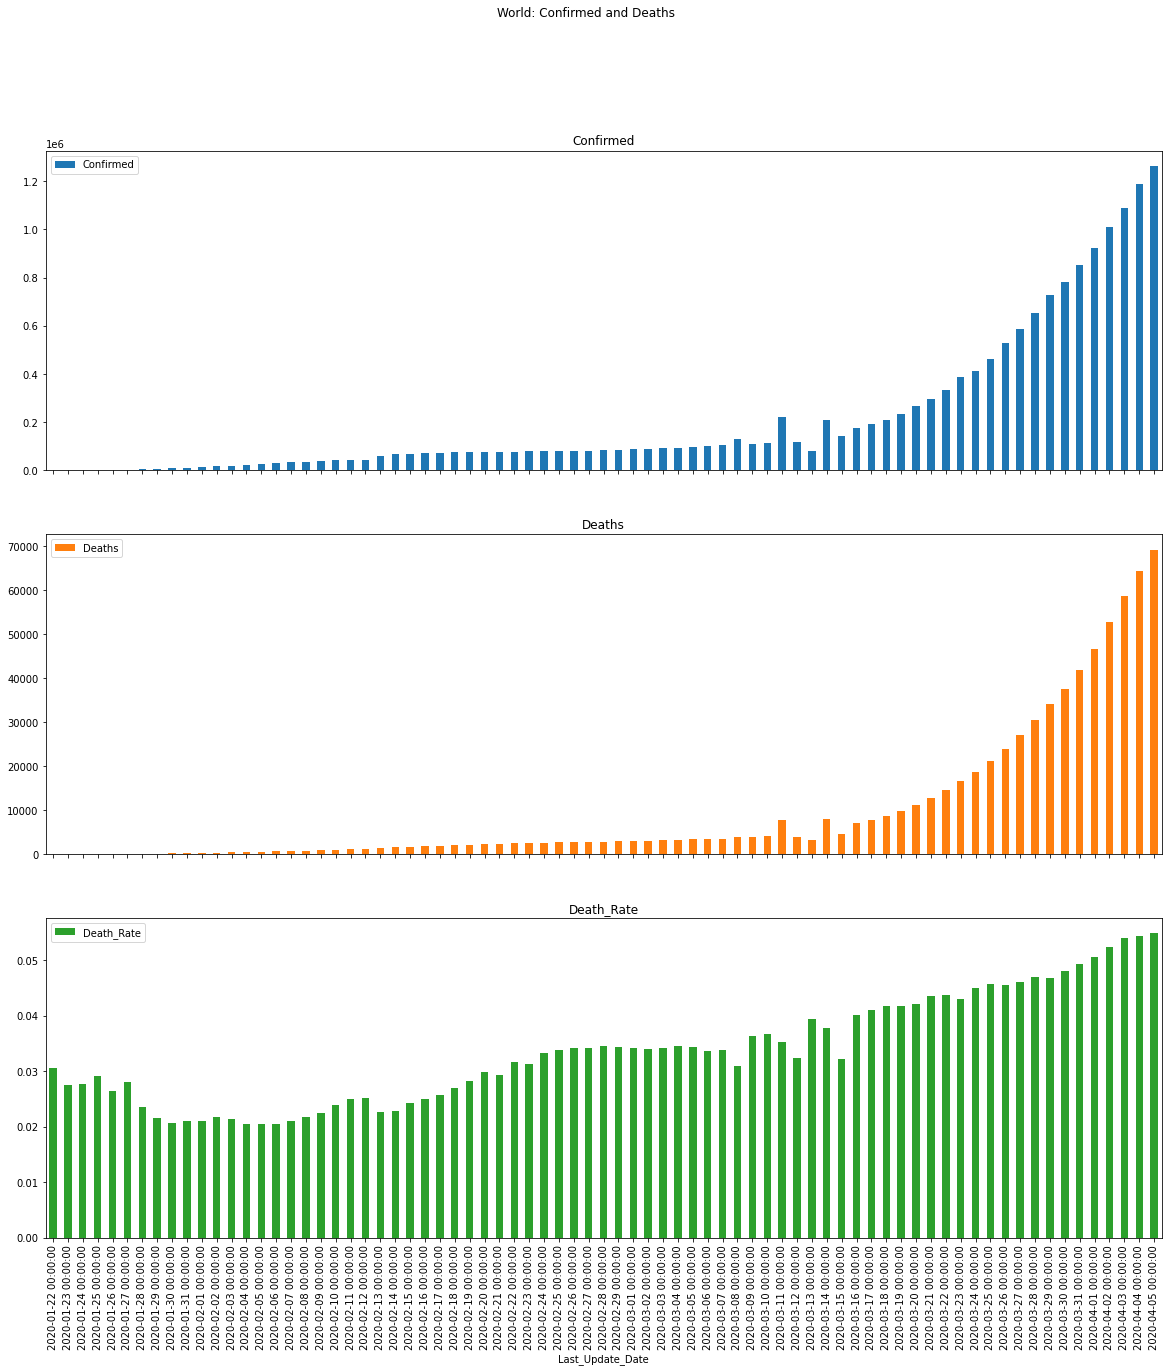

In [4]:
## Display world stats
show_world_stats = True
show_world_plots = True

## World-wise stats
cssedf_agg = cssedf.groupby('Last_Update_Date').agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Days_Since': 'max'})

## Create a column for death rate (deaths/confirmed).
cssedf_agg = cssedf_agg.assign(Death_Rate = lambda x: x.Deaths/x.Confirmed)

start_date = cssedf["Last_Update_Date"].min()
end_date = cssedf["Last_Update_Date"].max()

if show_world_stats:
    print("Data from:",start_date, "till:", end_date)
    print("Update on", end_date, 
          "(day {})".format(1+pd.Timedelta(end_date-start_date).days),
          "Confirmed:", cssedf_agg.at[end_date, "Confirmed"], 
          "Deaths:",cssedf_agg.at[end_date, "Deaths"],
          "Death Rate: {:.2f}%".format(100 * cssedf_agg.at[end_date,"Death_Rate"]))
if show_world_plots:
    ax = cssedf_agg.plot(kind='bar', y = ['Confirmed','Deaths','Death_Rate'], title="World: Confirmed and Deaths", figsize=(20,20), subplots=True)
    plt.show()


Data from: 2020-01-23 00:00:00 till: 2020-04-05 00:00:00
Update on 2020-04-05 00:00:00 (day 74) Confirmed: 5687.0 Deaths: 35.0 Death Rate: 0.62%


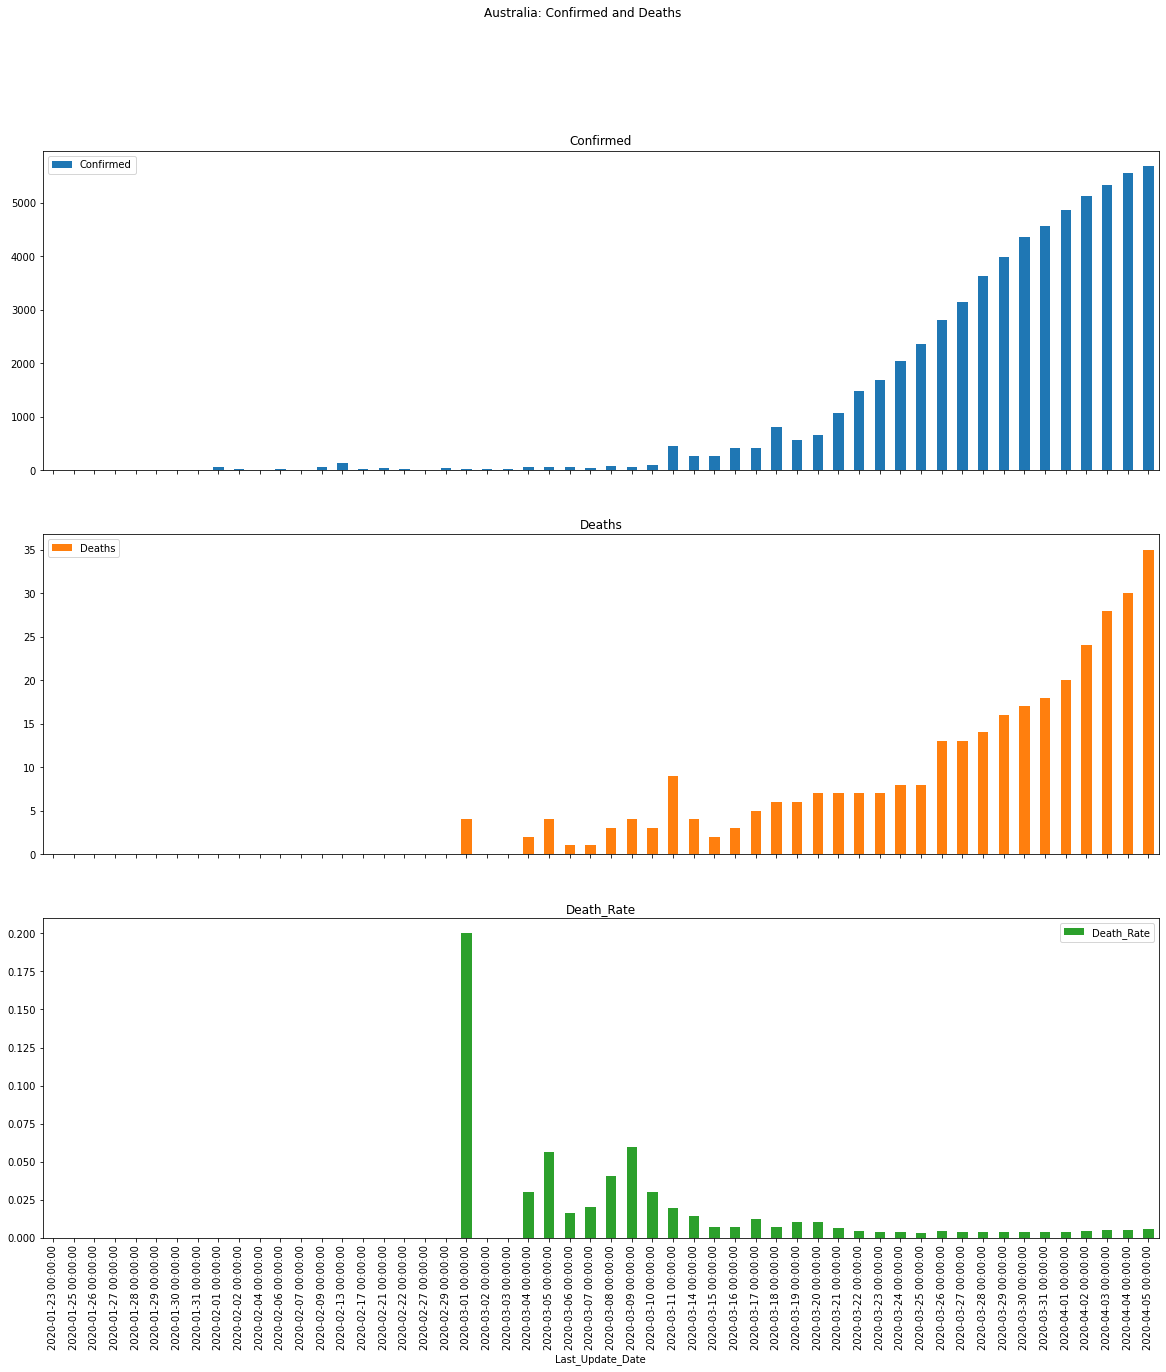

In [12]:
## Display countrywise stats
country = "Australia"
show_country_stats = True
show_country_plots = True

csse_country = cssedf[cssedf.Country_Region == country]
csse_country_agg = csse_country.groupby('Last_Update_Date').agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Days_Since': 'max'})

## Create a column for death rate (deaths/confirmed).
csse_country_agg = csse_country_agg.assign(Death_Rate = lambda x: (x.Deaths)/x.Confirmed)

#display(csse_country_agg)

start_date = csse_country["Last_Update_Date"].min()
end_date = csse_country["Last_Update_Date"].max()

if show_country_stats:
    print("Data from:",start_date, "till:", end_date)
    print("Update on", end_date, 
          "(day {})".format(1+pd.Timedelta(end_date-start_date).days),
          "Confirmed:", csse_country_agg.at[end_date, "Confirmed"], 
          "Deaths:",csse_country_agg.at[end_date, "Deaths"],
          "Death Rate: {:.2f}%".format(100 * csse_country_agg.at[end_date,"Death_Rate"]))
if show_country_plots:
    ax = csse_country_agg.plot(kind='bar', y = ['Confirmed','Deaths','Death_Rate'], title="{}: Confirmed and Deaths".format(country), figsize=(20,20), subplots=True)
    plt.show()


# Enrich data
Picked up world population dataset from https://www.kaggle.com/tanuprabhu/population-by-country-2020 (Same as StepFunction used)

In [6]:
## Read world population dataset
wpopdf = pd.read_csv("./addl_data/population_by_country_2020.csv", index_col=None, header=0, sep=",")

# keep only required columns
drop_cols=[ 'Yearly Change', 'Net Change', 'Migrants (net)', 'Fert. Rate',  'Urban Pop %', 'World Share']
wpopdf = wpopdf.drop(columns=drop_cols)
col_names = ["Country_Region","Population_2020", "Density","Land_Area","Median_Age"]
wpopdf.columns = col_names

## Fix several country names align them with the CSSE data
wpopdf.loc[wpopdf['Country_Region'] == "Czech Republic (Czechia)", 'Country_Region'] = "Czech Republic"
wpopdf.loc[wpopdf['Country_Region'] == "Cabo Verde", 'Country_Region'] = "Cape Verde"
wpopdf.loc[wpopdf['Country_Region'] == "Côte d'Ivoire", 'Country_Region'] = "Ivory Coast"
wpopdf.loc[wpopdf['Country_Region'] == "Timor-Leste", 'Country_Region'] = "East Timor"
wpopdf.loc[wpopdf['Country_Region'] == "Curaçao", 'Country_Region'] = "Curacao"
wpopdf.loc[wpopdf['Country_Region'] == "Réunion", 'Country_Region'] = "Reunion"
wpopdf.loc[wpopdf['Country_Region'] == "St. Vincent & Grenadines", 'Country_Region'] = "Saint Vincent and the Grenadines"
wpopdf.loc[wpopdf['Country_Region'] == "State of Palestine", 'Country_Region'] = "Palestine"
wpopdf.loc[wpopdf['Country_Region'] == "Saint Kitts & Nevis", 'Country_Region'] = "Saint Kitts and Nevis"

In [7]:
## Code to visually check countries and regions
wpop_countries = set(wpopdf['Country_Region'].unique())
csse_countries = set(cssedf['Country_Region'].unique())

#print("WPOP")
#print(sorted(wpop_countries))
#print("CSSE")
#print(sorted(csse_countries))

print("IN CSSE but NOT IN WORLD POP dataset")
display(sorted(csse_countries - wpop_countries))
#print("IN WORLD POP but NOT IN CSSE dataset")
#display(sorted(wpop_countries - csse_countries))

#display(wpopdf)

IN CSSE but NOT IN WORLD POP dataset


[]

In [8]:
econdf = pd.read_csv("addl_data/economic_freedom_index2019_data.csv", encoding = 'ISO-8859-1')

# display(econdf.columns)

# keep only required columns
keep_cols = set(['World Rank', 'Region Rank', 'Government Integrity', "Gov't Spending", 
                 'Fiscal Health', 'Country', 'GDP (Billions PPP)', 'GDP Growth Rate (%)',
                 '5 Year GDP Growth Rate (%)', 'GDP per Capita (PPP)', 'Unemployment (%)', 
                 'Inflation (%)', 'FDI Inflow (Millions)', 'Public Debt (% of GDP)'])
col_names = ['World_Rank', 'Region_Rank', 'Govt_Integrity', "Govt_Spending", 'Fiscal_Health',
       'Country', 'GDP_Billions', 'GDP_Growth_Rate', 'GDP_Growth_Rate_5yr', 'GDP_Per_Capita',
       'Unemployment_Rate', 'Inflation_Rate', 'FDI_Inflow_Millions', 'Public_Debt_Percent_GDP']

drop_cols = list(set(econdf.columns) - keep_cols)
econdf = econdf.drop(columns=drop_cols)
econdf.columns = col_names

## Fix several country names
econdf.loc[econdf['Country'] == "Congo, Democratic Republic of the Congo", 'Country'] = "DR Congo"
econdf.loc[econdf['Country'] == "Congo, Republic of", 'Country'] = "Congo"
econdf.loc[econdf['Country'] == "Cabo Verde", 'Country'] = "Cape Verde"
econdf.loc[econdf['Country'] == "Cote d'Ivoire", 'Country'] = "Ivory Coast"
econdf.loc[econdf['Country'] == "Hong Kong SAR", 'Country'] = "Hong Kong"
econdf.loc[econdf['Country'] == "Burma", 'Country'] = "Myanmar"
econdf.loc[econdf['Country'] == "Timor-Leste", 'Country'] = "East Timor"
econdf.loc[econdf['Country'] == "Taiwan ", 'Country'] = "Taiwan"
econdf.loc[econdf['Country'] == "Macau", 'Country'] = "Macao"
econdf.loc[econdf['Country'] == "Korea, North", 'Country'] = "North Korea"
econdf.loc[econdf['Country'] == "Korea, South", 'Country'] = "South Korea"
econdf.loc[econdf['Country'] == "Brunei Darussalam", 'Country'] = "Brunei"
econdf.loc[econdf['Country'] == "Kyrgyz Republic", 'Country'] = "Kyrgyzstan"
econdf.loc[econdf['Country'] == "Slovak Republic", 'Country'] = "Slovakia"
econdf.loc[econdf['Country'] == "Lao P.D.R.", 'Country'] = "Laos"

## strip the $, comma, % etc and convert to float
econdf['GDP_Billions'] = econdf['GDP_Billions'].str.replace(',', '').str.replace('$', '').astype('float')
econdf['GDP_Per_Capita'] = econdf['GDP_Per_Capita'].str.replace(',', '').str.replace('$', '').astype('float')
#display(econdf.dtypes)

## fill in NA and NaN values
maxs = econdf.max(axis=0)
mins = econdf.min(axis=0)
meds = econdf.median(axis=0)
navalues = {'World_Rank':maxs.World_Rank,
            'Region_Rank':maxs.Region_Rank, 
            'Govt_Integrity':mins.Govt_Integrity, 
            'Govt_Spending':mins.Govt_Spending,
            'Fiscal_Health':mins.Fiscal_Health,
            'GDP_Billions':mins.GDP_Billions,
            'GDP_Growth_Rate':mins.GDP_Growth_Rate,
            'GDP_Growth_Rate_5yr':mins.GDP_Growth_Rate_5yr,
            'GDP_Per_Capita':mins.GDP_Per_Capita,
            'Unemployment_Rate':maxs.Unemployment_Rate,
            'Inflation_Rate':maxs.Inflation_Rate,
            'FDI_Inflow_Millions':mins.FDI_Inflow_Millions,
            'Public_Debt_Percent_GDP':meds.Public_Debt_Percent_GDP
           }
econdf = econdf.fillna(value=navalues)
#display(econdf.isna().sum())

In [9]:
## Code to visually check countries and regions
econ_countries = set(econdf['Country'].unique())
csse_countries = set(cssedf['Country_Region'].unique())

#print("ECON")
#print(sorted(econ_countries))
#print("CSSE")
#print(sorted(csse_countries))

print("IN CSSE but NOT IN ECON dataset")
display(sorted(csse_countries - econ_countries))
#print("IN ECON but NOT IN CSSE dataset")
#display(sorted(econ_countries - csse_countries))

#display(econdf)

IN CSSE but NOT IN ECON dataset


['South Sudan', 'Western Sahara']

In [10]:
joindf = (cssedf.set_index('Country_Region').join(wpopdf.set_index('Country_Region')).join(econdf.set_index('Country')))

In [11]:
joindf.describe()

,Confirmed,Deaths,Days_Since,Day_Of_Week,Population_2020,Density,Land_Area,World_Rank,Region_Rank,Govt_Integrity,Govt_Spending,Fiscal_Health,GDP_Billions,GDP_Growth_Rate,GDP_Growth_Rate_5yr,GDP_Per_Capita,Unemployment_Rate,Inflation_Rate,FDI_Inflow_Millions,Public_Debt_Percent_GDP
count,53539.000000,53539.000000,53539.000000,53539.000000,5.353900e+04,53539.000000,5.353900e+04,53537.000000,53537.000000,53537.000000,53537.000000,53537.000000,53537.000000,53537.000000,53537.000000,53537.000000,53537.000000,53537.00000,53537.000000,53537.000000
mean,300.011151,13.550178,62.528194,3.175461,3.432331e+08,95.450942,8.178240e+06,23.264920,4.761268,72.903525,57.982300,56.363153,17159.942120,2.610008,2.482816,53910.631470,4.722657,4.15717,235121.105850,99.113084
std,3606.240658,267.539308,12.431696,2.086657,2.594384e+08,760.136030,2.778740e+06,32.005652,7.773687,13.131653,9.166811,12.646680,6329.828238,1.747063,1.403489,15272.208477,1.948200,45.23274,90617.823161,23.052056
min,0.000000,0.000000,0.000000,0.000000,3.812800e+04,2.000000,3.000000e+01,1.000000,1.000000,7.900000,0.000000,0.000000,0.200000,-14.000000,-16.100000,677.000000,0.100000,-0.90000,-8296.900000,0.000000
25%,0.000000,0.000000,61.000000,1.000000,3.310027e+08,36.000000,9.147420e+06,12.000000,2.000000,77.400000,57.100000,53.100000,19390.600000,2.300000,2.200000,59501.000000,4.400000,2.10000,275381.000000,107.800000
50%,3.000000,0.000000,65.000000,3.000000,3.310027e+08,36.000000,9.147420e+06,12.000000,2.000000,77.400000,57.100000,53.100000,19390.600000,2.300000,2.200000,59501.000000,4.400000,2.10000,275381.000000,107.800000
75%,19.000000,0.000000,69.000000,5.000000,3.310027e+08,36.000000,9.147420e+06,12.000000,2.000000,77.400000,57.100000,53.100000,19390.600000,2.300000,2.200000,59501.000000,4.400000,2.10000,275381.000000,107.800000
max,131646.000000,15887.000000,74.000000,6.000000,1.439324e+09,21645.000000,1.637687e+07,180.000000,47.000000,96.700000,96.600000,100.000000,23159.100000,70.800000,9.900000,139100.000000,27.300000,1087.50000,275381.000000,236.400000


# Approach
1. Fit the curve

    Clearly the way to predict the number of cases (confirmed/deaths) is a squence modeling problem. There are ways in which I have seen people attempt it by taking the existing observations and fit a regression model to predict the next several days. The inputs they take for those models are a sliding window over time and teh subsequet days as the labels to predict.

    This is NOT the correct way to go about this, as such models can predict only for the data that belongs to within the range of observed values. That is why for building such models the historic data must present the full range of values that the model can the use to extract the mathematcal function that represents the mapping between the current state and the value to predict. Also, what should represent the state is also key decision to solve this problem. More about it below. Using this time window method assumes the function (or the part of it of interest) is completely represented within that timewindow, and all the timewindows represent the same function. Both assumptions are invalid. Hence the model will end up coming up with a rising curve as the function, and it will very poorly approximate the reality.

    The solution I am proposing leverages the mathematical function well accepted by the epidemiologists, and fit the coefficients of that function to come up with the way the number of cases are developing in any region.

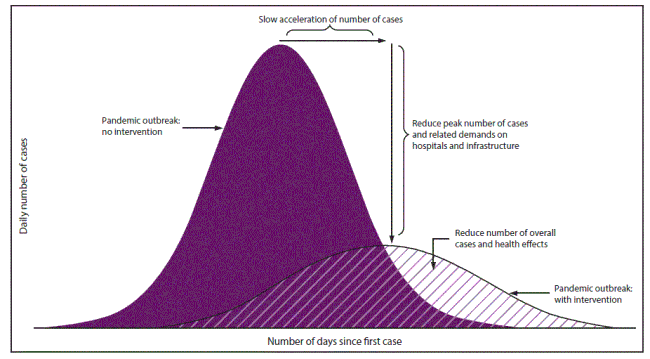

    The data demonstrates a very clean (non-noisey) pattern to help us model that with the limited amount of data we have available. I say that because fitting a curve with only some initia points can be very unreliable especially if the data has significant noise. But since the data is not noisey as seen above in this notebook, and since we are starting on this analysis now, the amount of data appears to be enough to get a reasonably good model.

    So, the first step is to ignore all factors that lead to the shape of the curve (population density, measures taken by the govt, ...) and just get the mapping as a function of time.

    What will it get us? At the least it can ive us a sense of where we are on the epidemic lifecyce, and when do we expect the things to start getting better, and an estimate of how many total fataities to expect, and such.

2. Use the features from the data to predict the coefficients of the curve.

    For this the modeling in #1 above will provide us training data (coefficient values are the labels) to determine how they are affected by those. Using explanabe AI techniques we can then further determine which are the most important factors.

    Note the modeling technique will need to be a sequence modeliing one - RNNs (LSTM, GRU).



My approximation for the epidemic curve is as given below. It has $m,w,x_0$ as the coefficients for the curve. $m$ is the total area under the curve, i.e., count of the people the curve is for, confirmed cases, or deaths; $w$ effects the width of the curve, smaller $w$ yields wider curve; $x_0$ is the center of the curve.
$$y = e(x) = \frac{mwe^{w(x-x_0)} } {(1+e^{w(x-x_0)})^2}$$

So, to fit the curve to the observed progression of number of cases, formulate the loss function, and use gradient descent to find $m,w,x_0$.

$$L=\sum_{i=1}^{N} \left(\frac {mwe^{w(x-x_0)}}{(1+e^{w(x-x_0)})^2} - y' \right)^2$$
